In [1]:
from common_funcs import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
df = pd.read_pickle('data/text_df_spelling_sent_tokenized')

First we will add in the column that indicates whether a country provided aid. That seems to have been dropped somewhere along the way.

In [4]:
aid_countries = pd.read_pickle('data/aid_countries')
aid_countries = aid_countries.str.lower().str.replace(' ', '')
aid_countries.replace('unitedstates', 'unitedstatesofamerica', inplace=True) # change this name for consistency
df['provided_aid'] = df.country.apply(lambda x: True if x in list(aid_countries) else False)

Sentiment analysis only works on English text so we will restrict analysis to English posts. Translation to English is possible but would require paying for a translation service which is outside the scope of this limited project.

In [19]:
df_en = df[df.language=='en'].copy()
df_en.shape

(814087, 8)

In [20]:
%%time
vader = SentimentIntensityAnalyzer()
df_en['compound_sentiment'] = df_en.text.apply(lambda x: vader.polarity_scores(x)['compound'])

CPU times: user 1min 46s, sys: 414 ms, total: 1min 46s
Wall time: 1min 47s


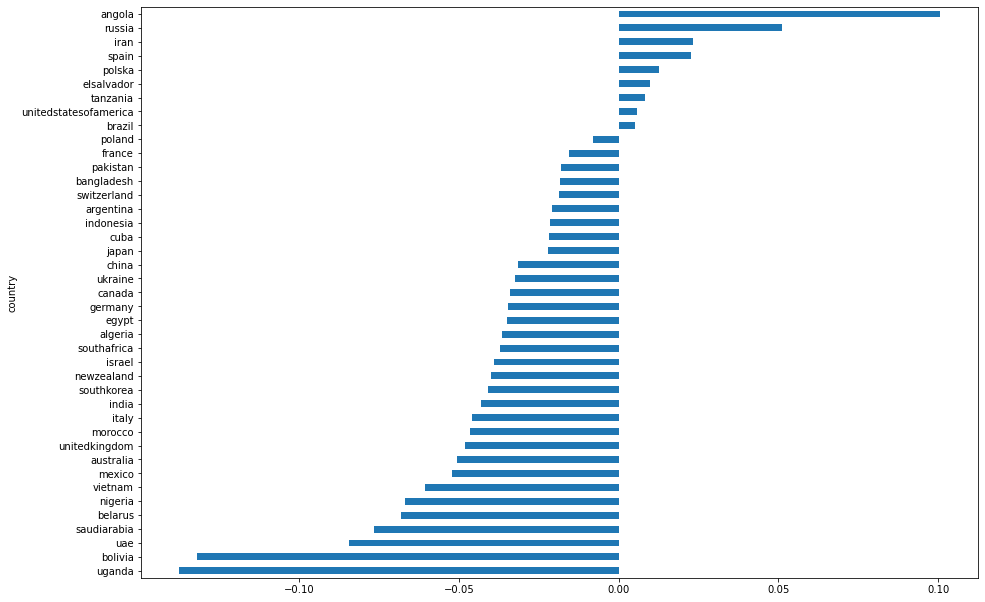

In [21]:
df_en.groupby('country')['compound_sentiment'].mean().sort_values().plot(kind='barh', figsize=(15,7*15/10));

This data needs cleaning. Angola has only 4 posts that all have sentiment scores of 0.0 except one which is at 0.4 so the score for the entire country gets a score of ~0.10. This is obviously not a statistically meaningful number of posts so we will remove all countries that have fewer than 1000 posts.

In [24]:
df_en[df_en.country=='angola']

,country,comments_or_subs,democracy_score,GDP,abstained,text,language,provided_aid,compound_sentiment
255987,angola,subs,3.37,70339.0,True,Live Webcam From Around Ukraine,en,False,0.0000
255988,angola,subs,3.37,70339.0,True,\n\nEuropean Union agrees to freeze assets of ...,en,False,0.4019
255988,angola,subs,3.37,70339.0,True,All Putin’s Men: Secret Records Reveal Money N...,en,False,0.0000
255989,angola,subs,3.37,70339.0,True,UKRAINE IV WEBCAMS,en,False,0.0000


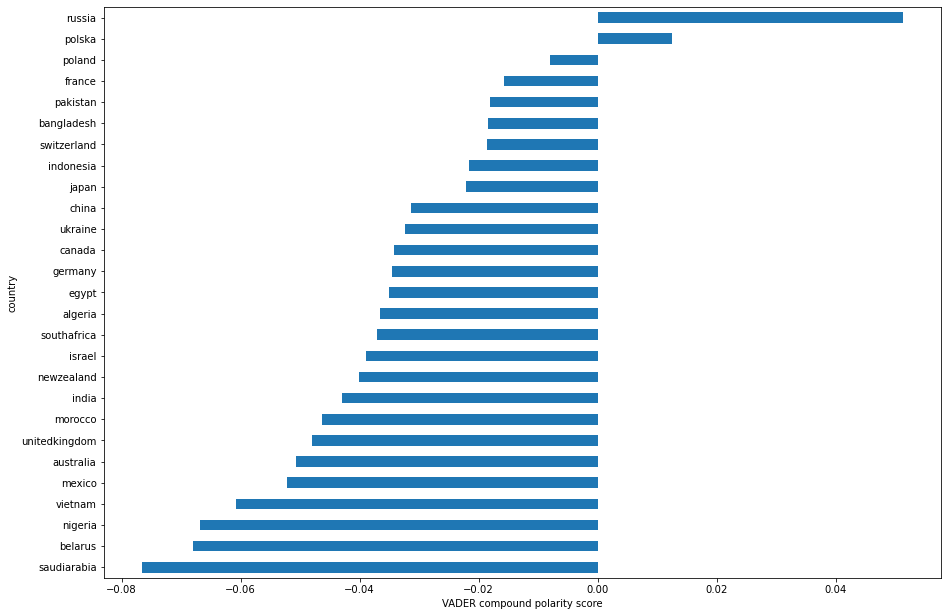

In [86]:
num_posts = df_en.groupby('country')['compound_sentiment'].count().sort_values(ascending=False)
countries = num_posts[num_posts >= 1000].index
df_en[df_en.country.isin(countries)].groupby('country')['compound_sentiment'].mean().sort_values().plot(kind='barh', figsize=(15,7*15/10));
plt.xlabel('VADER compound polarity score');

There is no clear lesson from the data. It is perhaps unsurprising that the Russia subreddit would show positive sentiment while the Ukrainian subreddit would show negative. However, why would the Belarus subreddit have such negative sentiment but the Russia one would not? Perhaps the Belarus subreddit contains mostly posts by English speaking dissidents while the Russia subreddit is subject to Russian government propaganda.

These sentiment scores are also pretty close to neutral so perhaps most posts are simply factual statements.

It is also possible that English speakers are strongly biased towards Ukraine. Note how the Poland subreddit in Polish has a positive sentiment while the subreddit in English has negative sentiment. It is possible that posters in English do not live in Poland but are rather posting about Polish issues in the Poland subreddit.

In [43]:
russia_sentiment = round(df_en[df_en.country=='russia'].compound_sentiment.mean(),3)
ukraine_sentiment = round(df_en[df_en.country=='ukraine'].compound_sentiment.mean(),3)

print(f'Russia subreddit sentiment: {russia_sentiment}')
print(f'Ukraine subreddit sentiment: {ukraine_sentiment}')  

Russia subreddit sentiment: 0.051
Ukraine subreddit sentiment: -0.032


What happens when we compare sentiment by democracy score? First, some countries are missing democracy scores. Let's fill these in. Somehow these got dropped.

In [61]:
sub_df = df_en[['country', 'democracy_score']]
sub_df[sub_df.democracy_score.isna()].country.unique()

array(['polska', 'unitedstatesofamerica', 'uae'], dtype=object)

In [62]:
df_en.loc[df_en.country == 'polska', 'democracy_score'] = 6.8
df_en.loc[df_en.country == 'unitedstatesofamerica', 'democracy_score'] = 7.85
df_en.loc[df_en.country == 'uae', 'democracy_score'] = 2.9

In [66]:
df_en.democracy_score = df_en.democracy_score.astype('float')

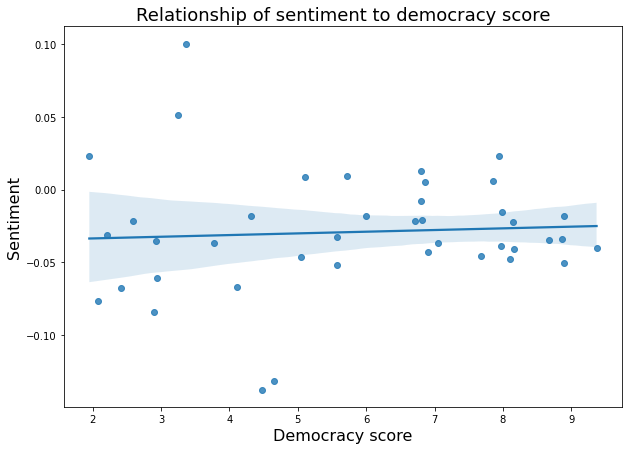

In [68]:
plt.figure(figsize=(10,7))
sns.regplot(data = df_en.groupby('country')[['democracy_score', 'compound_sentiment']].mean(), x='democracy_score', y='compound_sentiment');
plt.xlabel('Democracy score', fontsize=16)
plt.ylabel('Sentiment', fontsize=16)
plt.title('Relationship of sentiment to democracy score', fontsize=18);

No obvious relationship here. What about GDP?

In [73]:
# Correct an error in Cuba's GDP
df_en.loc[df_en.country=='cuba', 'GDP'] = 107352

In [76]:
df_en.GDP = df_en.GDP.astype('float')

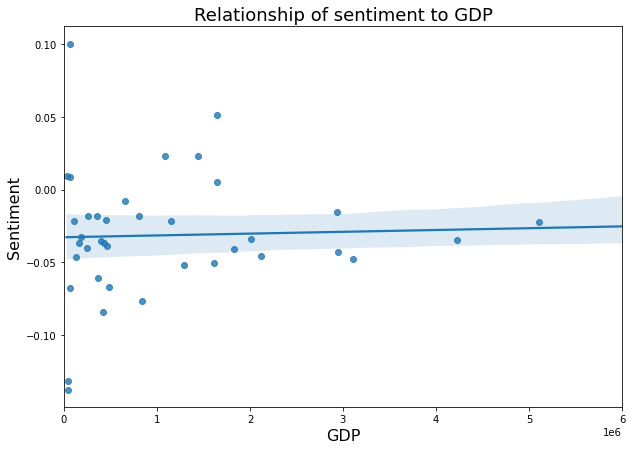

In [77]:
plt.figure(figsize=(10,7))
sns.regplot(data = df_en.groupby('country')[['GDP', 'compound_sentiment']].mean(),
                x='GDP', y='compound_sentiment');
plt.xlabel('GDP', fontsize=16)
plt.ylabel('Sentiment', fontsize=16)
plt.xlim([0, .6e7]) # Exclude two outliers
plt.title('Relationship of sentiment to GDP', fontsize=18);

No obvious relationship here either. Let's look at the extreme differences between countries that support Ukraine (did not abstain at the UN vote and did provide aid) with countries that support Russia (the inverse).

In [78]:
df_en.groupby(['abstained', 'provided_aid'])['compound_sentiment'].mean().reset_index()

,abstained,provided_aid,compound_sentiment
0,False,False,-0.031527
1,False,True,-0.034593
2,True,False,-0.048894
3,True,True,-0.036049


These numbers are pretty much the same all around. There isn't much to take away from these visualizations except perhaps that countries may not be taking into account the will of their people when deciding how to respond to the conflict. This wouldn't be surprising considering how quickly events evolve.

Let's move on to text analysis and in particular, look at the most common adjectives used to describe world leaders in the next notebook.

In [82]:
# Some final cleaning before moving on

df[['democracy_score', 'GDP']] = df[['democracy_score', 'GDP']].astype('float')
df.loc[df.country=='cuba', 'GDP'] = 107352.
df.loc[df.country == 'polska', 'democracy_score'] = 6.8
df.loc[df.country == 'unitedstatesofamerica', 'democracy_score'] = 7.85
df.loc[df.country == 'uae', 'democracy_score'] = 2.9

In [83]:
df.to_pickle('data/df_processed')

In [92]:
df_en.compound_sentiment.to_pickle('data/sentiment_scores')